In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pocomc as pc
from read_hdf5 import read_hdf5_convolution

### Load data

['ant_temp', 'freq', 'lst']


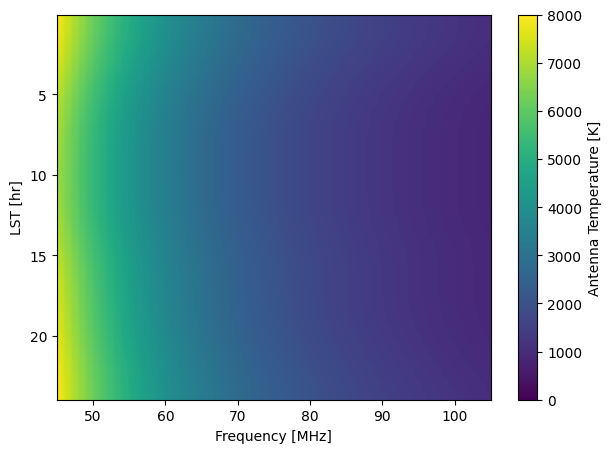

In [2]:
lst, freq, temp = read_hdf5_convolution(
    "simulations/CSA/CSA_beam_nominal_gsm_no_az_no_tilts_no_mountains.hdf5",
    print_key=True,
)
indx = (freq >= 45) * (freq <= 105)
freq = freq[indx]
temp = temp[:, indx]
nspec, nfreq = temp.shape
fg_mean = temp.mean(axis=0)  # avg spectrum, fg only

plt.figure(figsize=(7,5))
im = plt.imshow(
    temp, aspect="auto", extent=[freq.min(), freq.max(), lst.max(), lst.min()]
)
im.set_clim(0, 8000)
plt.colorbar(label="Antenna Temperature [K]")
plt.xlabel("Frequency [MHz]")
plt.ylabel("LST [hr]")
plt.show()

### Generate foreground model

(61, 6)


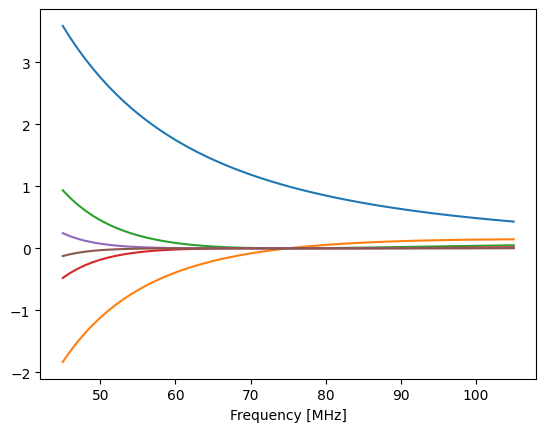

In [3]:
def design_mat(freq, nfg=5, beta=-2.5, nu_fg=75):
    """
    Generate a matrix of shape (Nfreq, Nfg) that evaluates the linlog model given a vector of foreground parameters.

    Parameters
    ----------
    freq : np.ndarray
        Frequencies to evaluate the model at.
    nfg : int
        Number of foreground terms.
    beta : float
        Spectral index of power law.
    nu_fg : float
        Normalization frequency in same units as freq.

    Returns
    -------
    A : np.ndarray
        The design matrix, i.e., a matrix with the linlog basis functions as the columns.
    
    """
    f_ratio = freq[:, None]/nu_fg  # dimensionless frequency ratio
    powers = np.arange(nfg)[None]
    A = f_ratio**beta * np.log(f_ratio)**powers
    return A

A_mean = design_mat(freq, nfg=6)
print(A_mean.shape)
nfg_mean = A_mean.shape[-1]

plt.figure()
for i in range(nfg_mean):
    plt.plot(freq, A_mean[:, i])
plt.xlabel("Frequency [MHz]")
plt.show()

### Noise

The noise covariance is taken to be diagonal. We assume systematic uncertainities have been calibrated and are left with radiometer noise. The noise in each frequency channel scales according to the radiometer equation, that is, the satndard deviation is proportional to the system temperature.

The first paper took the noise for the 24h avg spectrum to be 3 mK at 75 MHz and we follow that here.

In [4]:
rng = np.random.default_rng(seed=1913)  # initialize random number generator
noise_75 = 3e-3
noise_std = noise_75 * fg_mean/fg_mean[freq==75]
noise_mean = rng.normal(scale=noise_std)

# add noise to fg
fg_mean += noise_mean

sigma_mean = np.diag(noise_std**2)
sigma_inv_mean = np.diag(1/noise_std**2)

In [7]:
Cinv_mean = A_mean.T @ sigma_inv_mean @ A_mean
C_mean = np.linalg.inv(Cinv_mean)  # foreground parameter covariance
sigma_fg_mean = A_mean @ C_mean @ A_mean.T
V_mean = np.linalg.inv(np.linalg.inv(sigma_fg_mean) - sigma_inv_mean)
total_cov_mean = sigma_mean + V_mean

### Global signal

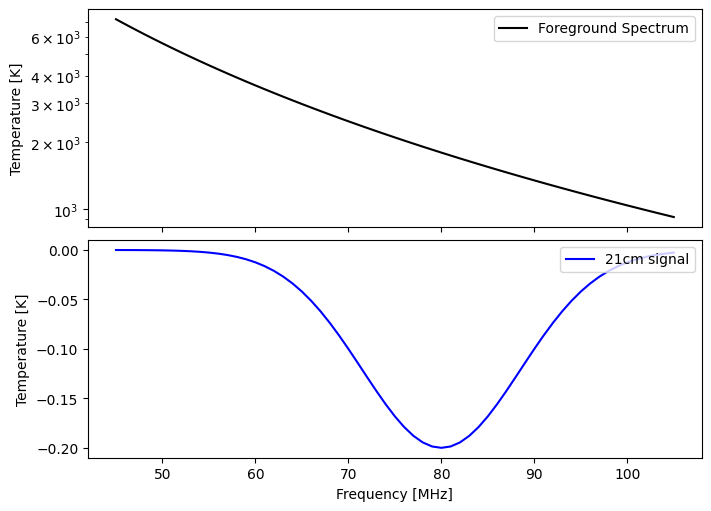

In [8]:
# injected global signal
def gauss(f, a=-0.2, w=20, nu21=80):
    """
    Gaussian in terms of frequency, amplitude, FWHM, and center freq. Default parameters are the ones used in Monsalve et al. 2023b.
    """
    return a * np.exp(-1/2 *((f-nu21) / w)**2 *8*np.log(2))

t21 = gauss(freq)
d_mean = fg_mean + t21  # total spectrum

fig, axs = plt.subplots(figsize=(7,5), nrows=2, sharex=True, constrained_layout=True)
axs[0].semilogy(freq, fg_mean, label="Foreground Spectrum", c="k")
axs[1].plot(freq, t21, label="21cm signal", c="blue")
axs[1].set_xlabel("Frequency [MHz]")
for ax in axs:
    ax.legend(loc="upper right")
plt.setp(axs, ylabel="Temperature [K]")
plt.show()

### Initialize and run sampler

In [41]:
def log_prior(params, bounds):
    """
    Uniform priors on all parameters.
    """
    if np.any(params < bounds.T[0]) or np.any(params > bounds.T[1]):
        return -np.inf
    else:
        return 0.0

# Parameter bounds (a, w, nu21)
bounds = np.array([[-1., 1.], [1., 60.], [45., 105.]])
n_dim = len(bounds)

def log_likelihood(params):
    t21_model = gauss(freq, *params)
    res = d_mean - t21_model  # residual
    theta_hat = C_mean @ A_mean.T @ sigma_inv_mean @ res
    dstar = res - A_mean @ theta_hat  # eq 8 in Monsalve 2018
    lnL = -1/2 * dstar.T @ np.linalg.inv(total_cov_mean) @ dstar  # XXX disregarding the constant prefactor
    return lnL
    

n_particles = 1000
prior_samples = rng.uniform(size=(n_particles, n_dim), low=bounds.T[0], high=bounds.T[1])

sampler = pc.Sampler(
    n_particles,
    n_dim,
    log_likelihood,
    log_prior,
    vectorize_likelihood=True,
    bounds=bounds,
    log_prior_args=[bounds]
)


In [10]:
sampler.run(prior_samples)
results = sampler.results

Iter: 42it [03:47,  5.41s/it, beta=1, calls=131000, ESS=0.954, logZ=-42.2, accept=0.232, N=2, scale=1.09, corr=0.708]      


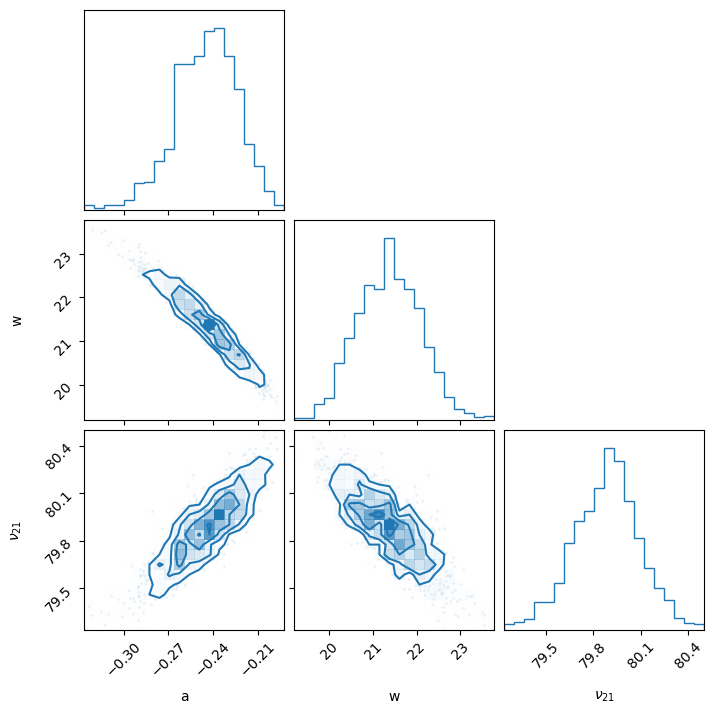

In [11]:
pc.plotting.corner(results, labels=['a', 'w', r'$\nu_{21}$']);

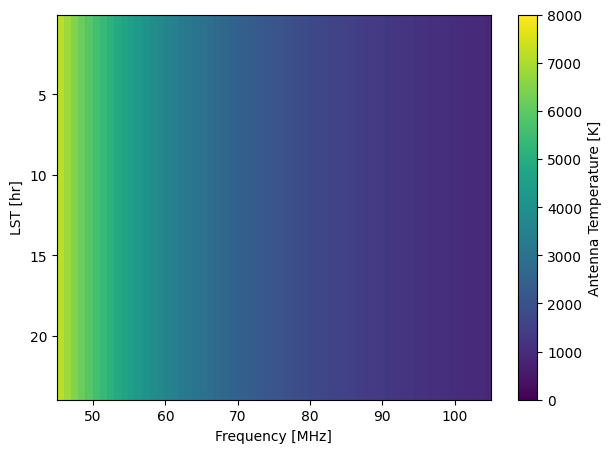

In [12]:
NBINS = 5
fg_bin = temp[:-(nspec%NBINS)].reshape(nspec//NBINS, NBINS, nfreq).mean(axis=0)  # this discards the last 6 min integration

plt.figure(figsize=(7,5))
im = plt.imshow(
    fg_bin, aspect="auto", extent=[freq.min(), freq.max(), lst.max(), lst.min()]
)
im.set_clim(0, 8000)
plt.colorbar(label="Antenna Temperature [K]")
plt.xlabel("Frequency [MHz]")
plt.ylabel("LST [hr]")
plt.show()

### Foreground models

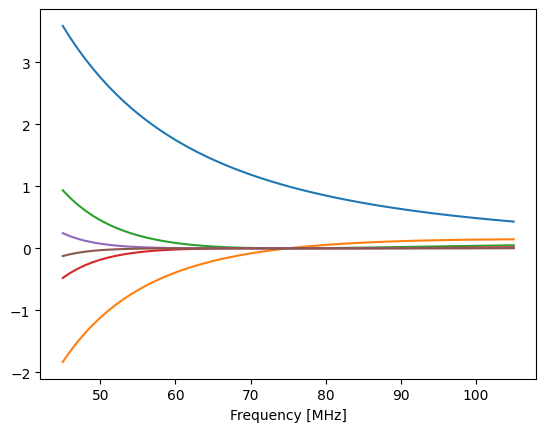

In [13]:
# using same nfg for all bins at the moment, use Bayesian evidence / BIC later to determine for each bin
nfg = [6] * NBINS
max_terms = np.max(nfg)

A_max = design_mat(freq, nfg=max_terms)

plt.figure()
for i in range(max_terms):
    plt.plot(freq, A_max[:, i])
plt.xlabel("Frequency [MHz]")
plt.show()

### Noise

Compared to the 24hr avg case, we take the standard deviation of the noise to be $\sqrt{\mathrm{nbins}}$ greater to reflect the fact that we need to observe for longer if we average less. Moreover, following the radiometer equation, the noise relates to that in the 24avg bin proprtionaly to the system temperature.

In [14]:
noise_std_bin = noise_std[None] * (fg_bin/fg_mean[None]) * np.sqrt(NBINS)
noise_bin = rng.normal(scale=noise_std_bin)

# add noise to fg
fg_bin += noise_bin

# create a cov matrix for each bin
sigma_bin = [np.diag(sig**2) for sig in noise_std_bin]
sigma_inv_bin = [np.diag(1/sig**2) for sig in noise_std_bin]

In [15]:
A_bin = []
Cinv_bin = []
C_bin = []
sigma_fg_bin = []
V_bin = []

for i in range(NBINS):
    nterms = nfg[i]
    A = A_max[:, :nterms]
    Cinv = A.T @ sigma_bin[i] @ A
    C = np.linalg.inv(Cinv)
    sigma_fg = A @ C @ A.T
    V = np.linalg.inv(np.linalg.inv(sigma_fg) - sigma_inv_bin[i])

    A_bin.append(A)
    Cinv_bin.append(Cinv)
    C_bin.append(C)
    sigma_fg_bin.append(sigma_fg)
    V_bin.append(V)

### Foreground spectra with injected 21cm signal

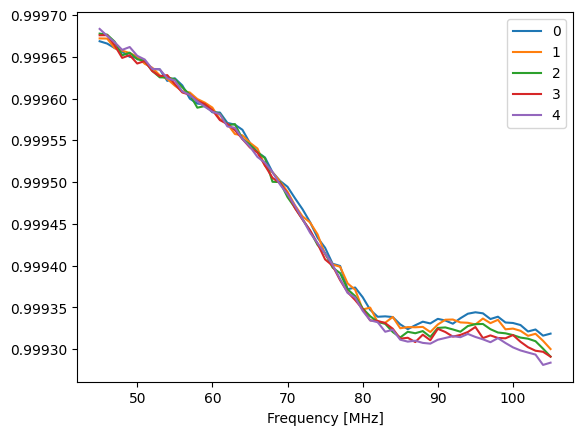

In [35]:
d_bin = fg_bin + t21

plt.figure()
for i, spec in enumerate(d_bin):
    plt.plot(freq, spec/fg_mean, label=f"{i}")
plt.xlabel("Frequency [MHz]")
plt.legend()
plt.show()

### Initialize and run sampler

In [49]:
def log_likelihood(params):
    t21_model = gauss(freq, *params)
    lnL = 0
#    for i in range(NBINS):
    for i in range(1):
        d = d_bin[i]
        A = A_bin[i]
        C = C_bin[i]
        sigma_inv = sigma_inv_bin[i]
        sigma = sigma_bin[i]
        V = V_bin[i]
        
        res = d - t21_model  # residual
        theta_hat = C @ A.T @ sigma_inv @ res
        dstar = res - A @ theta_hat  # eq 8 in Monsalve 2018
        total_cov = sigma + V
        lnL -= 1/2 * dstar.T @ np.linalg.inv(total_cov) @ dstar  # XXX disregarding the constant prefactor
    #print(lnL)
    return lnL
    

sampler = pc.Sampler(
    n_particles,
    n_dim,
    log_likelihood,
    log_prior,
    vectorize_likelihood=True,
    bounds=bounds,
    log_prior_args=[bounds]
)


In [60]:
A_bin[0].shape

(61, 6)

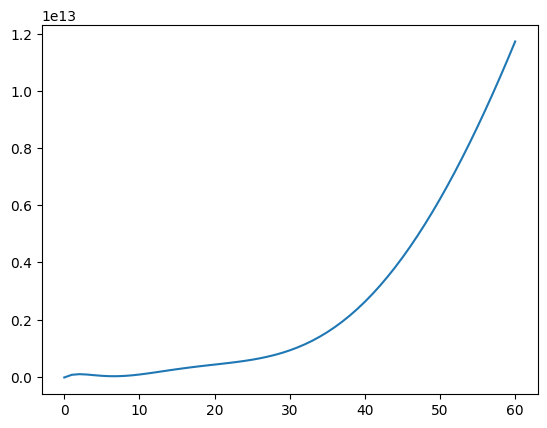

In [65]:
plt.figure()
plt.plot(A_bin[0] @ C_bin[0] @ A_bin[0].T @ sigma_inv_bin[0] @ rres)
#plt.plot(A_mean @ C_mean @ A_mean.T @ sigma_inv_mean @ mres)
plt.show()

[9.23547088e+11 9.19280006e+12 5.89260964e+13 2.36346465e+14
 4.69138016e+14 3.46464357e+14]
[2107.42415532  125.55747167 -135.38872365  -10.73325314   22.96836026
   20.18929604]


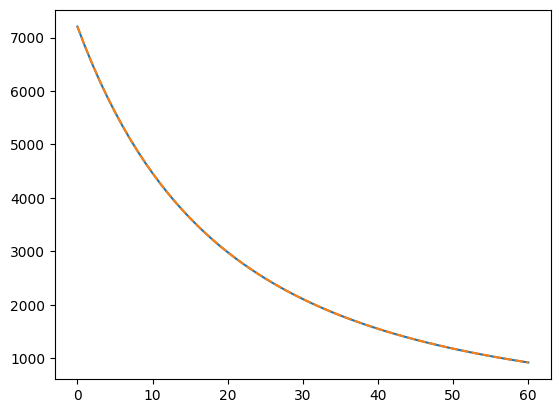

In [55]:
tt21 = gauss(freq, *prior_samples[0])
rres = d_bin[0] - tt21
mres = d_mean - tt21

ttheta_hat = C_bin[0] @ A_bin[0].T @ sigma_inv_bin[0] @ rres
mtheta_hat = C_mean @ A_mean.T @ sigma_inv_mean @ mres

print(ttheta_hat)
print(mtheta_hat)

plt.figure()
plt.plot(rres)
plt.plot(mres, ls="--")
plt.show()

In [37]:
sampler.run(prior_samples)
results = sampler.results

Iter: 2it [00:10,  5.01s/it, beta=4.11e-38, calls=31000, ESS=0.95, logZ=-385, accept=0, N=30, scale=0.484, corr=1]/home/christian/Documents/research/MIST/global_signal/.venv/lib/python3.10/site-packages/pocomc/tools.py:25: RuntimeWarning: invalid value encountered in subtract
  logw_normed = logw - logw_max
Iter: 2it [00:10,  5.01s/it, beta=1, calls=31000, ESS=nan, logZ=-385, accept=0, N=30, scale=0.484, corr=1]        /home/christian/Documents/research/MIST/global_signal/.venv/lib/python3.10/site-packages/pocomc/tools.py:45: RuntimeWarning: invalid value encountered in subtract
  logw_normed = logw - logw_max
/home/christian/Documents/research/MIST/global_signal/.venv/lib/python3.10/site-packages/pocomc/tools.py:48: RuntimeWarning: invalid value encountered in reduce
  return logw_max + np.logaddexp.reduce(logw_normed) - np.log(N)
Iter: 2it [00:10,  5.01s/it, beta=1, calls=31000, ESS=nan, logZ=nan, accept=0, N=30, scale=0.484, corr=1] /home/christian/Documents/research/MIST/global_sig

AssertionError: 

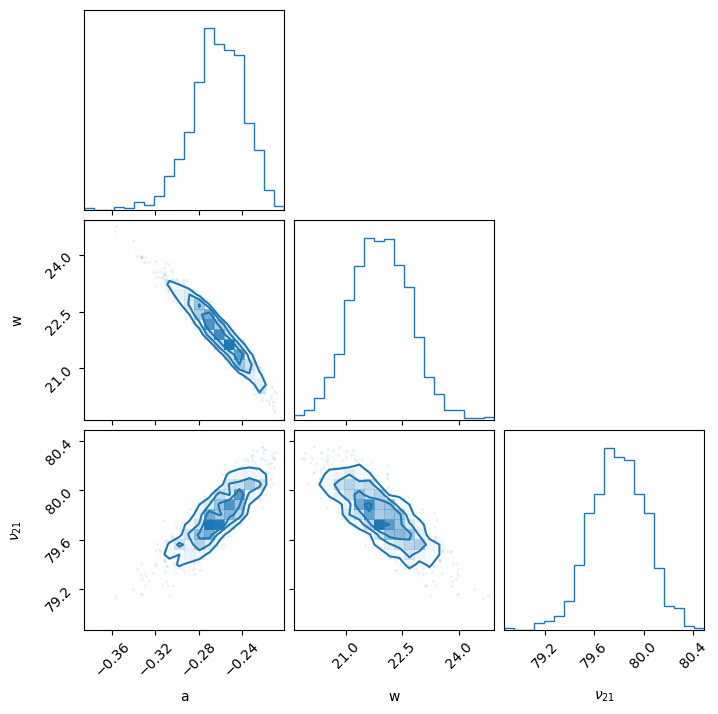

In [148]:
pc.plotting.corner(results, labels=['a', 'w', r'$\nu_{21}$']);